# SpaCy and Gender Analysis Installs

## Installs 

In [ ]:
!pip install -U spacy

In [ ]:
!python -m spacy download en_core_web_sm


In [ ]:
pip install wordcloud

In [ ]:
!pip install gender-guesser

##Import librairies and data

In [ ]:
import spacy
import pandas as pd
nlp = spacy.load("en_core_web_sm")

In [ ]:
import gender_guesser.detector as gender

In [ ]:
df = pd.read_parquet('gs://nlp_nyt_data_datascience/Project4/nyt_data.parquet')

# Functions toolbox

##Extracting 'Person' type of entity using SpaCy

In [ ]:
#Extracts PERSON entities from article/text
def get_named_persons(article):
    doc = nlp(article)
    named_entities = []
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            named_entities.append(ent.text)
    return named_entities

##Looking for feminine pronouns or the words "women" , "woman" "lady", "ladies"

In [ ]:
# Define a function to check if a text mentions women
def mentions_women(text):
    doc = nlp(text)
    for token in doc:
        if (token.pos_ == "PRON" and token.lower_ in ["she", "her", "hers", "herself"]) or (token.pos_ == "NOUN" and token.lower_ in ["woman", "women", "lady", "ladies", "dame"]) :
            return True
    return False


##Using Gender detector to classify the first names found at index 0 in array named_entities

In [ ]:
def check_for_female_name(sentences):
    detector = gender.Detector()
    for sentence in sentences:
        words = sentence.split()
        if words:
            first_word = words[0]
            if detector.get_gender(first_word) == 'female':
                return True
    return False

def check_for_female_named_entities(row):
    if row['named_entities']:
        return check_for_female_name(row['named_entities'])

## Batch Processing by decades looking at both excerpts and titles

In [ ]:
#apply the function by batches:
def process_in_batches(df, batch_size=1000):
    start_idx = 0
    end_idx = batch_size
    while start_idx < len(df):
        # Get a batch of rows
        batch = df.iloc[start_idx:end_idx]
        
        # Apply mentions_women function to the excerpt column
        batch['mentions_women_excerpt'] = batch['excerpt'].apply(mentions_women)
        batch['mentions_women_title'] = batch['title'].apply(mentions_women)
        batch = batch[(batch["mentions_women_excerpt"] == True) | (batch["mentions_women_title"] == True)]
        
        # Increment start_idx and end_idx to move to the next batch
        start_idx += batch_size
        end_idx += batch_size
        
        print(f'end index = {end_idx}')
        #return df
        yield batch

Selects 600 rows randomly for one decade, processing in batches not useful but used just in case we decide to increase number of rows to > 1,000.

ONLY LOOKING AT ARTICLES WITH EXCERPTS AND TITLES

In [ ]:
import random

#Function to process batches and returns for each decade
def decades_processing(df, df_new, decade=1920):
    #select decade
    df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
    print(f'(decade = {decade})')
    #Only with excerpts
    df_decade = df_decade[df_decade["excerpt"] != '']
    # Select 600 rows randomly for each year, seed=suposedly allows for the same random rows to be selected each time this is ran...
    df_decade = df_decade.groupby('year').apply(lambda x: x.sample(n=min(600, len(x)), random_state=random.seed()))
    print(f'df_decade size = {df_decade.shape[0]}')
    # Process the dataframe in batches
    for batch in process_in_batches(df_decade):
        df_new = df_new.append(batch)
        print(f'df new size = {df_new.shape[0]}')
    return df_new

DO.NOT.USE.

In [ ]:
#DO NOT USE UNLESS YOU HAVE A SUPER COMPUTER FROM NASA THANK YOU
#Function to process batches by decades and returns after one decade
def decades_processing_while(df, df_new, decade=1920):
    while decade < 2021:
        #select decade
        df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
        print(f'(decade = {decade})')
        #Only with excerpts
        df_decade = df_decade[df_decade["excerpt"] != '']
        # Process the dataframe in batches
        for batch in process_in_batches(df_decade):
            df_new = df_new.append(batch)
            print(f'df new size = {df_new.shape[0]}')
        decade += 10
    return df_new

## Auto-decade processing (starts at 1920, ends at 2009 included)

Selects 600 rows randomly for one decade, processing in batches not useful but used just in case we decide to increase number of rows to > 1,000

In [ ]:
def decades_processing_while_600rows_stops2010(df, df_new, decade=1920):
    while decade < 2010:
        #select decade
        df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
        print(f'(decade = {decade})')
        #Only with excerpts
        df_decade = df_decade[df_decade["excerpt"] != '']
        # Select 600 rows randomly for each year, seed=suposedly allows for the same random rows to be selected each time this is ran...
        df_decade = df_decade.groupby('year').apply(lambda x: x.sample(n=min(600, len(x)), random_state=random.seed()))
        # Process the dataframe in batches
        for batch in process_in_batches(df_decade):
            df_new = df_new.append(batch)
            print(f'df new size = {df_new.shape[0]}')
        decade += 10
    return df_new

Before using any of the batch processing function, need to create a new empty df to keep appending results

In [ ]:
# Create the new DataFrame with the same columns as the original DataFrame
df_new = pd.DataFrame(columns=df.columns)

# Run analysis

In [ ]:
df_women = decades_processing_while_600rows_stops2010(df, df_new, decade=1920)

(decade = 1920)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


end index = 2000
df new size = 45
end index = 3000
df new size = 92
end index = 4000
df new size = 118
end index = 5000
df new size = 146
end index = 6000
df new size = 187
end index = 7000
df new size = 215
(decade = 1930)
end index = 2000
df new size = 240
end index = 3000
df new size = 263
end index = 4000
df new size = 289
end index = 5000
df new size = 313
end index = 6000
df new size = 342
end index = 7000
df new size = 377
(decade = 1940)
end index = 2000
df new size = 404
end index = 3000
df new size = 432
end index = 4000
df new size = 448
end index = 5000
df new size = 462
end index = 6000
df new size = 482
end index = 7000
df new size = 502
(decade = 1950)
end index = 2000
df new size = 520
end index = 3000
df new size = 539
end index = 4000
df new size = 560
end index = 5000
df new size = 586
end index = 6000
df new size = 610
end index = 7000
df new size = 627
(decade = 1960)
end index = 2000
df new size = 641
end index = 3000
df new size = 659
end index = 4000
df new size

Last decade = 2010 to 2020 included, so created a specific function for this decade.

In [ ]:
def decades_processing_2010(df, df_new, decade=2010):
    #select decade
    df_decade = df[(df['year'] >= decade) & (df['year'] <= (decade + 10))]
    print(f'(decade = {decade})')
    #Only with excerpts
    df_decade = df_decade[df_decade["excerpt"] != '']
    # Select 600 rows randomly for each year, seed=suposedly allows for the same random rows to be selected each time this is ran...
    df_decade = df_decade.groupby('year').apply(lambda x: x.sample(n=min(600, len(x)), random_state=random.seed()))
    print(f'df_decade size = {df_decade.shape[0]}')
    # Process the dataframe in batches
    for batch in process_in_batches(df_decade):
        df_new = df_new.append(batch)
        print(f'df new size = {df_new.shape[0]}')
    return df_new

df_women_2010_2020 = decades_processing_2010(df, df_new)
df_women_2010_2020.shape[0]

(decade = 2010)
df_decade size = 6515


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


end index = 2000
df new size = 67
end index = 3000
df new size = 113
end index = 4000
df new size = 148
end index = 5000
df new size = 217
end index = 6000
df new size = 310
end index = 7000
df new size = 420
end index = 8000
df new size = 470


470

In [ ]:
df_women.tail()

year                                              title  \
(2009, 15972624)  2009  The multimedia revue of the life and work of S...   
(2009, 15895382)  2009  Good style mixes high-ticket items with brilli...   
(2009, 16093203)  2009                                    Monologue &#124   
(2009, 15874897)  2009  (From Theselby.com) The Digital Ramble explore...   
(2009, 15894204)  2009  An article on Aug. 15 about efforts by the bre...   

                                                            excerpt  \
(2009, 15972624)  its limited run will end on June 13. The roste...   
(2009, 15895382)  Nicolas Ghesquière whipped them into dresses a...   
(2009, 16093203)  Aired Friday night on "Late Night With Jimmy F...   
(2009, 15874897)  then, still in bed, she continued to write unt...   
(2009, 15894204)              there is no 12.7-caliber. Corrections   

                 mentions_women_excerpt mentions_women_title  
(2009, 15972624)                  False                 True  
(2009, 15895382)                   True                False  
(2009, 16093203)                   True                False  
(2009, 15874897)                   True                 True  
(2009, 15894204)                  False                 True

In [ ]:
df_women_2010_2020.tail()

year                                              title  \
(2020, 17302413)  2020  She was the first black female graduate of the...   
(2020, 17305784)  2020            Ms. Nguyen’s writing career was budding   
(2020, 17321938)  2020  A reader shares her story of competing in her ...   
(2020, 17325506)  2020  A Des Moines reader notes, “As the field winno...   
(2020, 17325372)  2020  Her “Ashton Manual,” published in 1999, has be...   

                                                            excerpt  \
(2020, 17302413)  she also was a major supporter of sickle cell ...   
(2020, 17305784)  she was also an inspiring teacher of first-gen...   
(2020, 17321938)  the experience of reading. Female Runners (35+...   
(2020, 17325506)  dealing with hearing loss. Amy Klobuchar’s ‘Do...   
(2020, 17325372)                   Helped People Quit Anxiety Drugs   

                 mentions_women_excerpt mentions_women_title  
(2020, 17302413)                   True                 True  
(2020, 17305784)                   True                False  
(2020, 17321938)                  False                 True  
(2020, 17325506)                  False                 True  
(2020, 17325372)                  False                 True

In [ ]:
df_women_100years = df_women.append(df_women_2010_2020)

# Data Visualization: Wordclouds by decade



## Women nouns

In [ ]:
from collections import Counter #for counting
import seaborn as sns #for visualization
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud

def get_word_cloud(df, decade):
    df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
    text = df_decade['excerpt'].str.cat(sep=' ')
    # spaCy enforces a max limit of 1000000 characters for NER and similar use cases.
    # Since `text` might be longer than that, we will slice it off here
    max_length = 1000000-1
    text = text[:max_length]
    doc = nlp(text)
    female_topics = []
    for token in doc:
        if (not token.is_stop) and (token.pos_ == "NOUN") and (len(str(token))>2) and (str(token) != 'years') and (str(token) != 'year') and (str(token) != 'Years') and (str(token) != 'Year') and (str(token) != 'Today') and (str(token) != 'today'):
            female_topics.append(token)

    female_topics = [str(x) for x in female_topics]
    plt.figure(figsize=(10,5))
    wordcloud = WordCloud(background_color="white",
                          stopwords = STOP_WORDS,
                          max_words=45,
                          max_font_size=30,
                          random_state=42
                         ).generate(str(female_topics))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f'Decade: {decade}')
    plt.show()

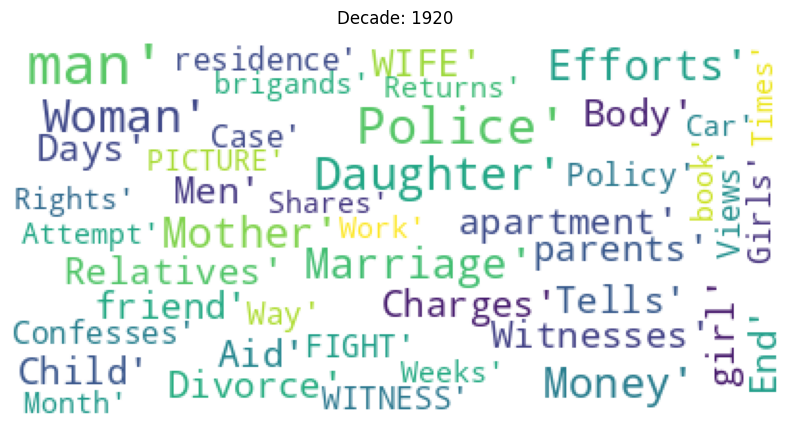

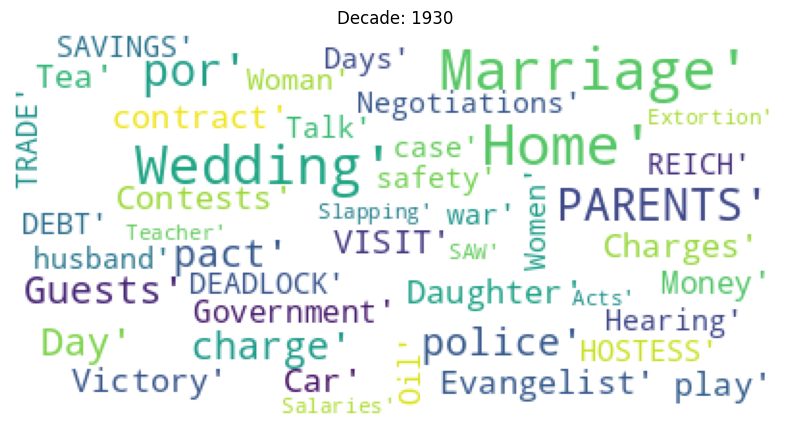

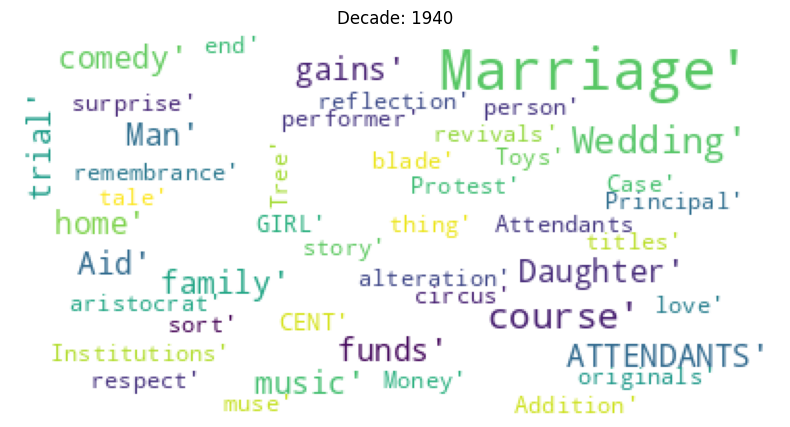

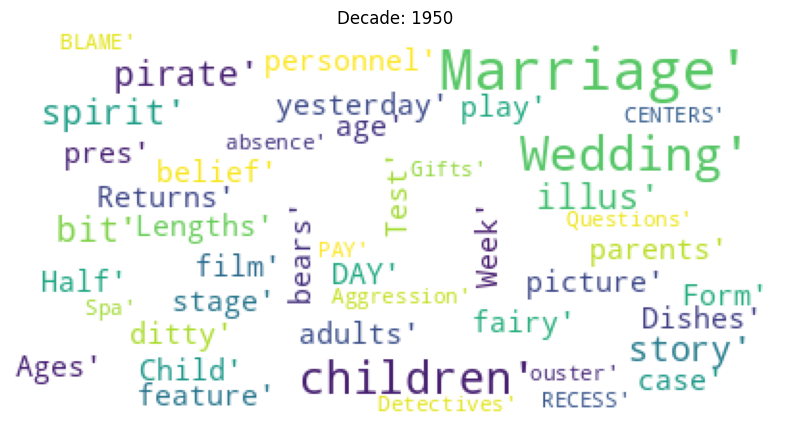

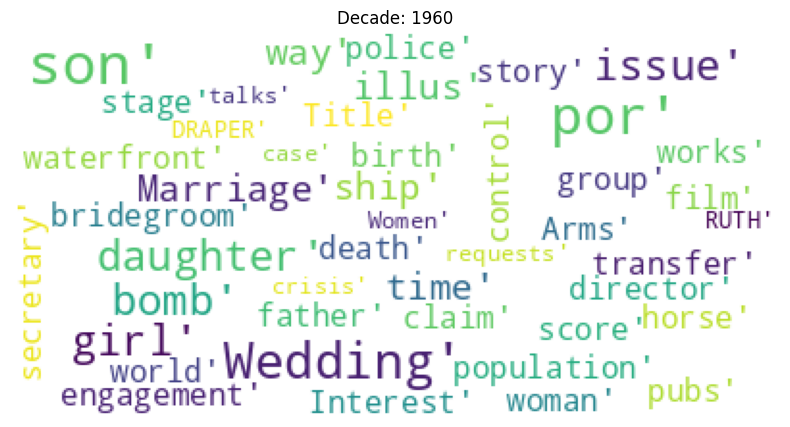

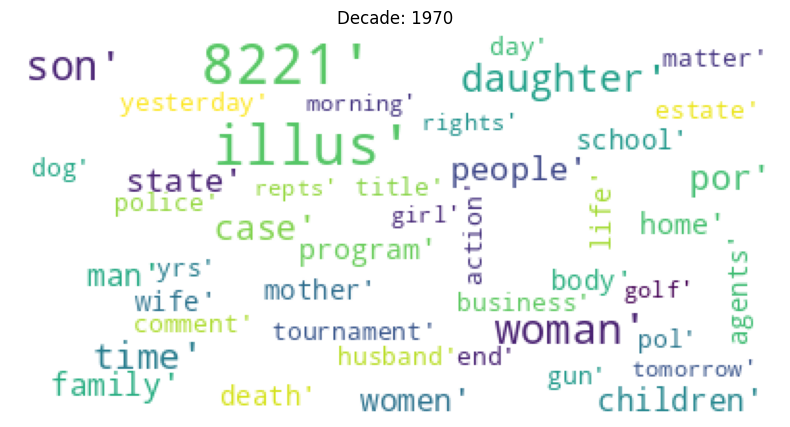

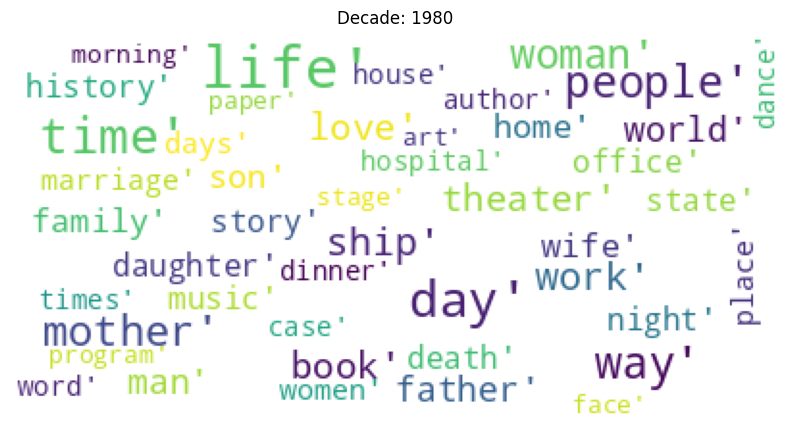

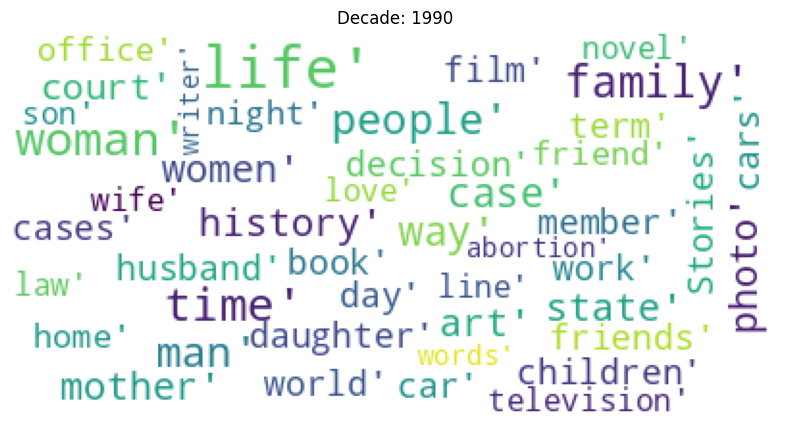

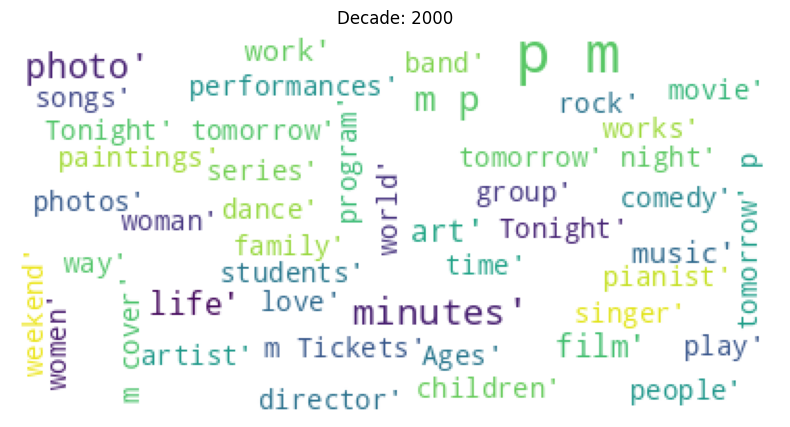

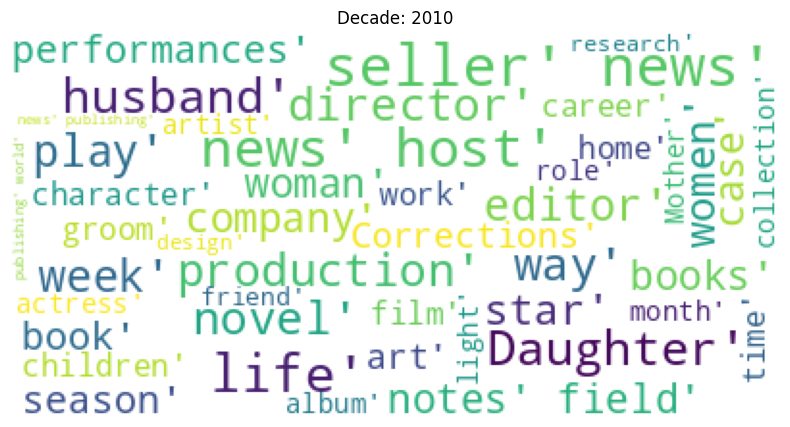

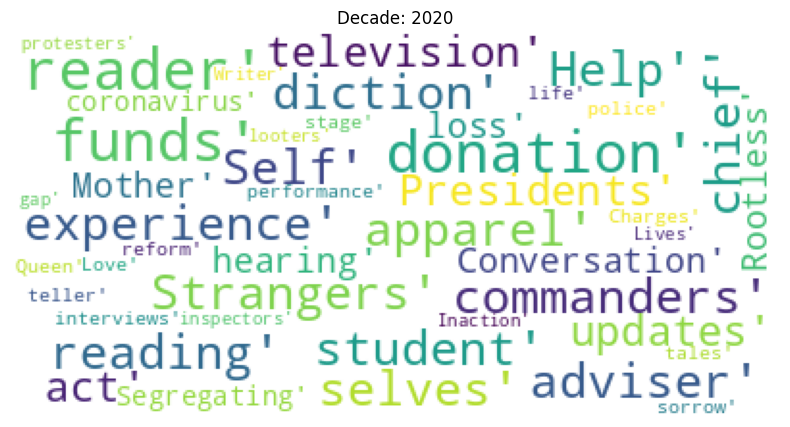

In [ ]:
decade = 1920
while decade < 2021:
    get_word_cloud(df_women_100years, decade)
    decade += 10



## Percentage of articles mentioning women

In [ ]:
#Calculate the ratio of women mentioned for each year
# Group the DataFrame by year
year_groups = df_women_100years.groupby('year')

# Calculate the number of rows per year
year_rows = year_groups.size()
    
# Calculate the ratio of rows to 600 for each year
women_mentions_percent = year_rows.apply(lambda count: (count / 600)*100)
    
# Create a DataFrame with the year and ratio columns
result_df = pd.DataFrame({'percentage of articles mentioning women': women_mentions_percent})

In [ ]:
result_df

percentage of articles mentioning women
year                                         
1920                                 3.666667
1921                                 5.666667
1922                                 5.000000
1923                                 2.166667
1924                                 3.166667
...                                       ...
2016                                 8.500000
2017                                 9.333333
2018                                 8.000000
2019                                12.166667
2020                                10.000000

[101 rows x 1 columns]

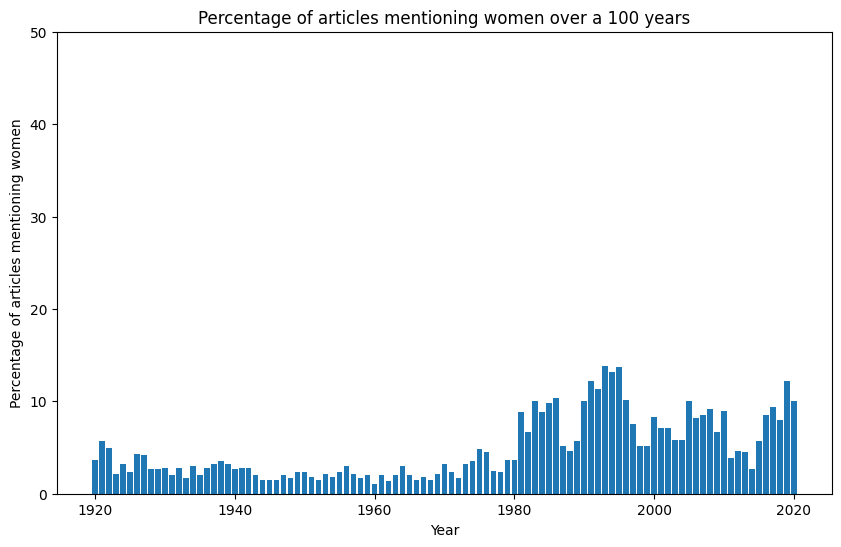

In [ ]:
# create a bar graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(result_df.index, result_df['percentage of articles mentioning women'])
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of articles mentioning women')
ax.set_title('Percentage of articles mentioning women over a 100 years')
ax.set_ylim(0, 50)
plt.show()

## Wordclouds for women adjectives

In [ ]:
def get_word_cloud_adj(df, decade):
    df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
    text = df_decade['excerpt'].str.cat(sep=' ')
    # spaCy enforces a max limit of 1000000 characters for NER and similar use cases.
    # Since `text` might be longer than that, we will slice it off here
    max_length = 1000000-1
    text = text[:max_length]
    doc = nlp(text)
    female_topics = []
    for token in doc:
        if (not token.is_stop) and (token.pos_ == "ADJ") and (len(str(token))>2):
            female_topics.append(token)

    female_topics = [str(x) for x in female_topics]
    plt.figure(figsize=(10,5))
    wordcloud = WordCloud(background_color="white",
                          stopwords = STOP_WORDS,
                          max_words=45,
                          max_font_size=30,
                          random_state=42
                         ).generate(str(female_topics))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f'Decade: {decade}')
    plt.show()

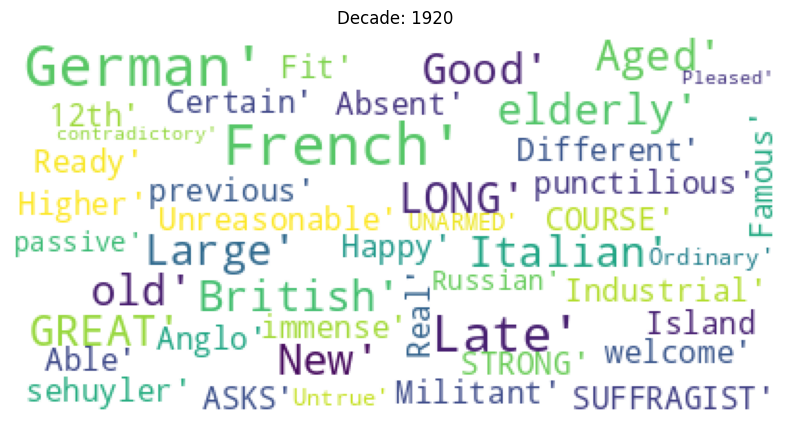

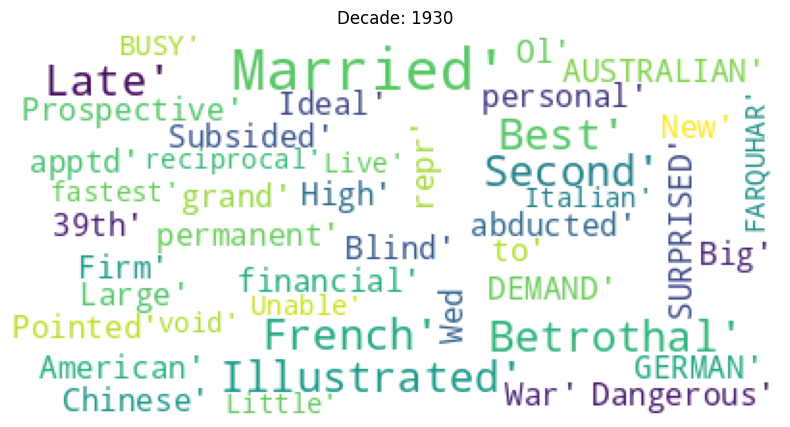

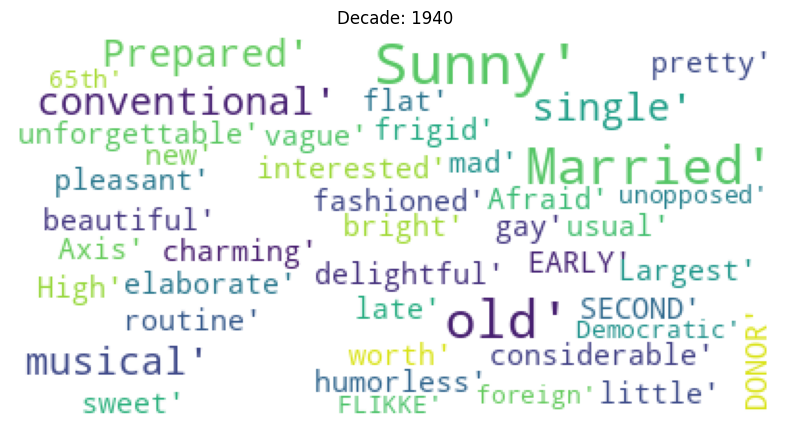

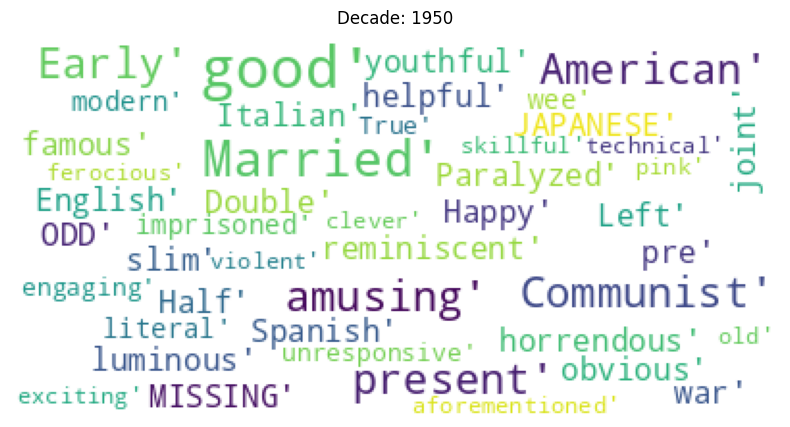

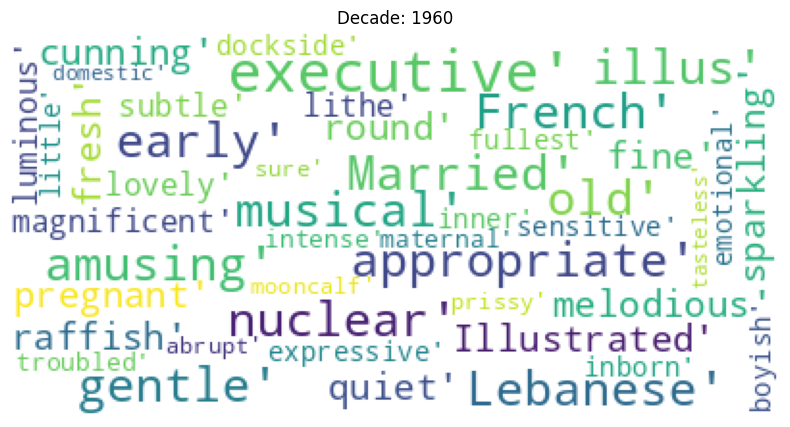

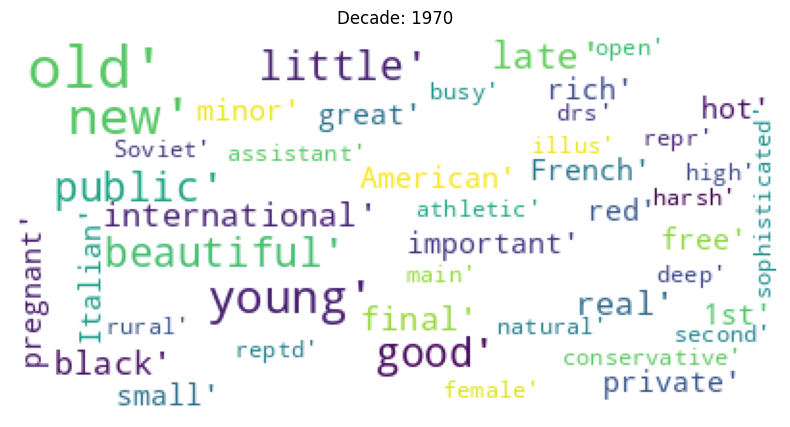

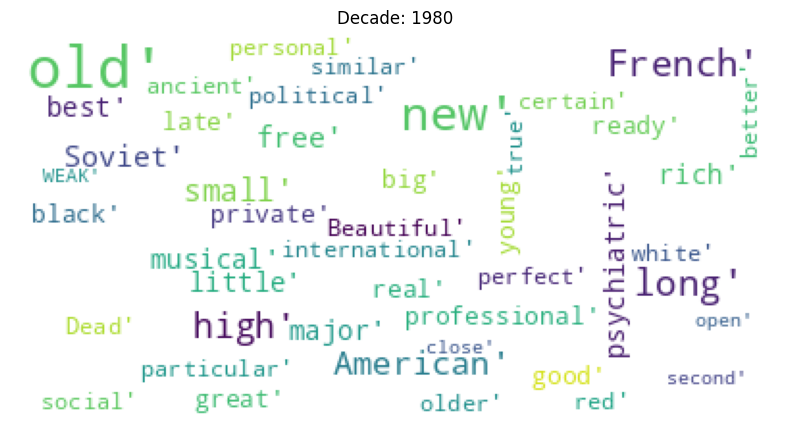

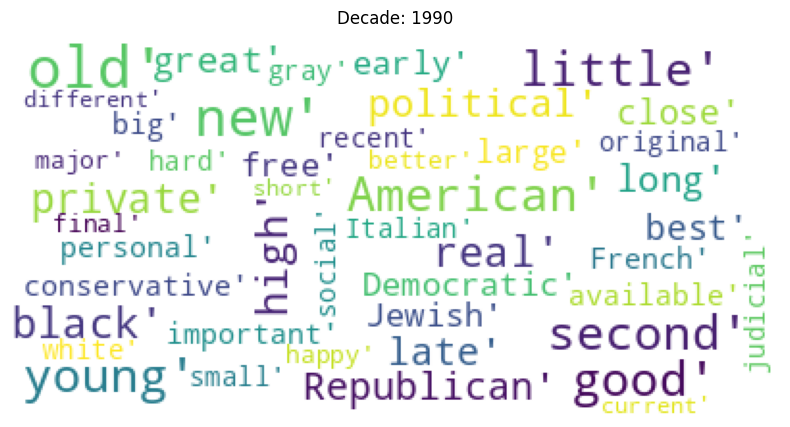

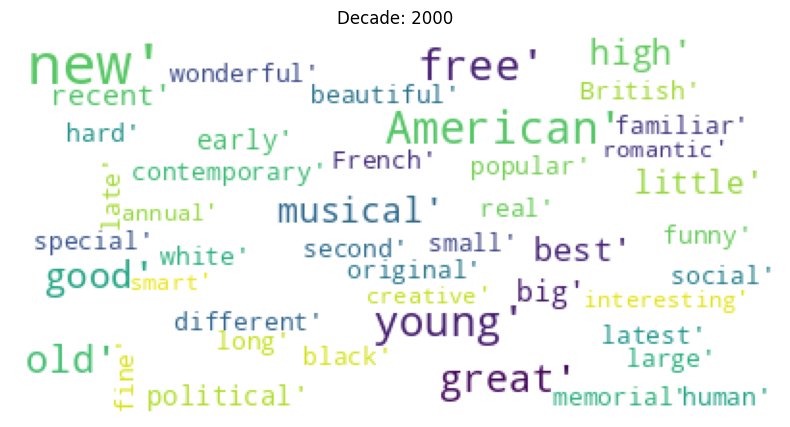

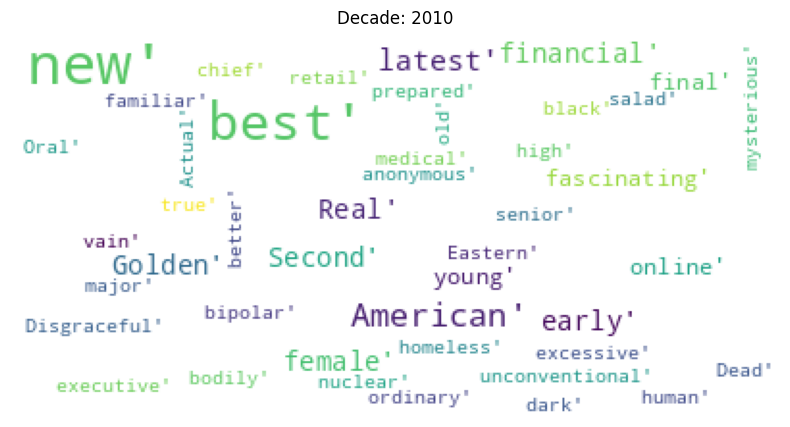

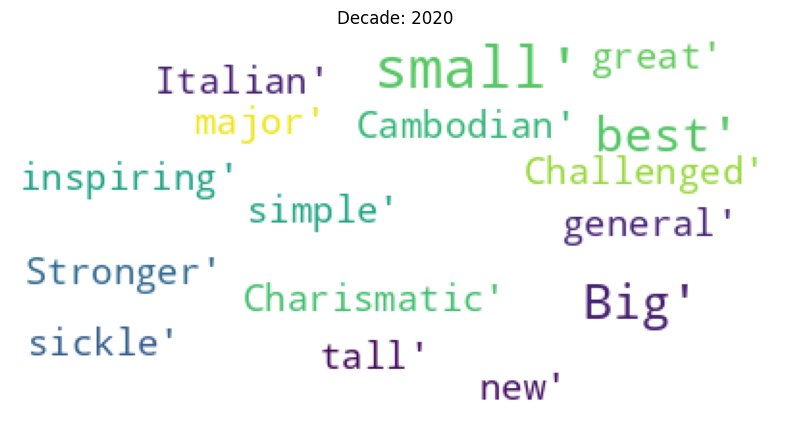

In [ ]:
decade = 1920
while decade < 2021:
    get_word_cloud_adj(df_women_100years, decade)
    decade += 10


# Men analysis

## Functions to extract mentions of men

In [ ]:
# Define a function to check if a text mentions men
def mentions_men(text):
    doc = nlp(text)
    for token in doc:
        if (token.pos_ == "PRON" and token.lower_ in ["he", "him", "his", "himself"]) or (token.pos_ == "NOUN" and token.lower_ in ["men", "man"]):
            return True
    return False

## Function to batch process

In [ ]:
#apply the function mentions_men by batches:
def process_in_batches_men(df, batch_size=1000):
    start_idx = 0
    end_idx = batch_size
    while start_idx < len(df):
        # Get a batch of rows
        batch = df.iloc[start_idx:end_idx]
        
        # Apply mentions_women function to the excerpt column
        batch['mentions_men_excerpt'] = batch['excerpt'].apply(mentions_men)
        batch['mentions_men_title'] = batch['title'].apply(mentions_men)
        batch = batch[(batch["mentions_men_excerpt"] == True) | (batch["mentions_men_title"] == True)]
        
        # Increment start_idx and end_idx to move to the next batch
        start_idx += batch_size
        end_idx += batch_size
        
        #return df
        yield batch

In [ ]:
#takes in df, selects 600 rows every year and processes batches per decades per 1,000 rows
def decades_processing_while_600rows_stops2010_men(df, df_new, decade=1920):
    while decade < 2010:
        #select decade
        df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
        print(f'(decade = {decade})')
        #Only with excerpts
        df_decade = df_decade[df_decade["excerpt"] != '']
        # Select 600 rows randomly for each year, seed=suposedly allows for the same random rows to be selected each time this is ran...
        df_decade = df_decade.groupby('year').apply(lambda x: x.sample(n=min(600, len(x)), random_state=random.seed()))
        # Process the dataframe in batches
        for batch in process_in_batches_men(df_decade):
            df_new = df_new.append(batch)
            print(f'df new size = {df_new.shape[0]}')
        decade += 10
    return df_new


In [ ]:
# Create the new DataFrame with the same columns as the original DataFrame
df_new = pd.DataFrame(columns=df.columns)

df_men = decades_processing_while_600rows_stops2010_men(df, df_new, decade=1920)

(decade = 1920)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


df new size = 136
df new size = 275
df new size = 387
df new size = 550
df new size = 674
df new size = 789
(decade = 1930)
df new size = 926
df new size = 1027
df new size = 1130
df new size = 1236
df new size = 1322
df new size = 1414
(decade = 1940)
df new size = 1494
df new size = 1576
df new size = 1635
df new size = 1720
df new size = 1787
df new size = 1867
(decade = 1950)
df new size = 1934
df new size = 1996
df new size = 2074
df new size = 2156
df new size = 2231
df new size = 2306
(decade = 1960)
df new size = 2384
df new size = 2474
df new size = 2612
df new size = 2713
df new size = 2847
df new size = 2986
(decade = 1970)
df new size = 3161
df new size = 3370
df new size = 3593
df new size = 3781
df new size = 3945
df new size = 4101
(decade = 1980)
df new size = 4368
df new size = 4700
df new size = 5049
df new size = 5375
df new size = 5605
df new size = 5816
(decade = 1990)
df new size = 6113
df new size = 6480
df new size = 6866
df new size = 7146
df new size = 7338
df

In [ ]:
def decades_processing_2010_men(df, df_new, decade=2010):
    #select decade
    df_decade = df[(df['year'] >= decade) & (df['year'] <= (decade + 10))]
    print(f'(decade = {decade})')
    #Only with excerpts
    df_decade = df_decade[df_decade["excerpt"] != '']
    # Select 600 rows randomly for each year, seed=suposedly allows for the same random rows to be selected each time this is ran...
    df_decade = df_decade.groupby('year').apply(lambda x: x.sample(n=min(600, len(x)), random_state=random.seed()))
    print(f'df_decade size = {df_decade.shape[0]}')
    # Process the dataframe in batches
    for batch in process_in_batches_men(df_decade):
        df_new = df_new.append(batch)
        print(f'df new size = {df_new.shape[0]}')
    return df_new

df_men_2010_2020 = decades_processing_2010_men(df, df_new)

df_men = df_men.append(df_men_2010_2020)

(decade = 2010)
df_decade size = 6515


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


df new size = 169
df new size = 284
df new size = 381
df new size = 526
df new size = 703
df new size = 896
df new size = 1000


## Calculate the percentage of articles mentioning men

In [ ]:
#Calculate the ratio of men mentioned for each year
# Group the DataFrame by year
year_groups = df_men.groupby('year')

# Calculate the number of rows per year
year_rows = year_groups.size()
    
# Calculate the ratio of rows to 600 for each year
men_mentions_percent = year_rows.apply(lambda count: (count / 600)*100)
    
# Create a DataFrame with the year and ratio columns
result_df_men = pd.DataFrame({'percentage of articles mentioning men': men_mentions_percent})

In [ ]:
result_df_men

percentage of articles mentioning men
year                                       
1920                              12.333333
1921                              15.500000
1922                              15.166667
1923                              10.833333
1924                              10.666667
...                                     ...
2016                              17.833333
2017                              18.000000
2018                              15.000000
2019                              20.000000
2020                              20.166667

[101 rows x 1 columns]

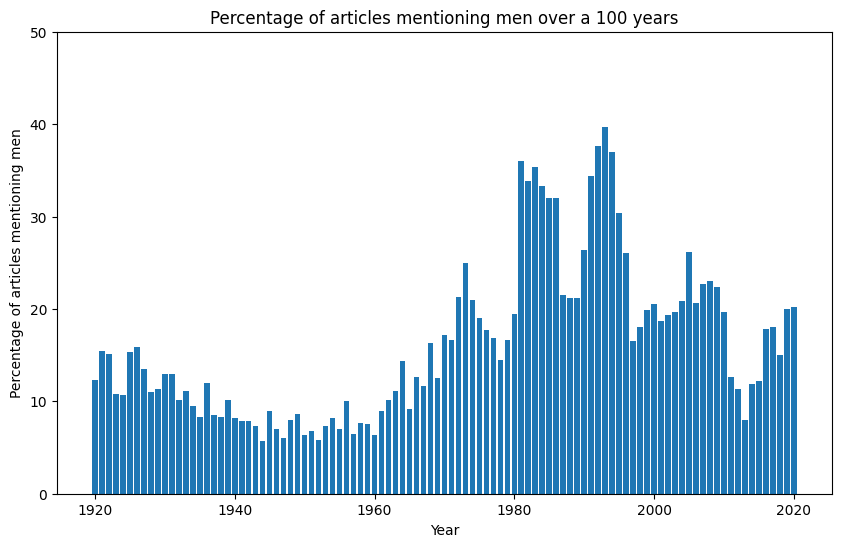

In [ ]:
# create a bar graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(result_df.index, result_df_men['percentage of articles mentioning men'])
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of articles mentioning men')
ax.set_title('Percentage of articles mentioning men over a 100 years')
ax.set_ylim(0, 50)
plt.show()

## WordClouds for men

In [ ]:
def get_word_cloud_men(df, decade):
    df_decade = df[(df['year'] >= decade) & (df['year'] < (decade + 10))]
    text = df_decade['excerpt'].str.cat(sep=' ')
    # spaCy enforces a max limit of 1000000 characters for NER and similar use cases.
    # Since `text` might be longer than that, we will slice it off here
    max_length = 1000000-1
    text = text[:max_length]
    doc = nlp(text)
    male_topics = []
    for token in doc:
        if (not token.is_stop) and (token.pos_ == "NOUN") and (len(str(token))>2) and (str(token) != 'years') and (str(token) != 'year') and (str(token) != 'Years') and (str(token) != 'Year') and (str(token) != 'Today') and (str(token) != 'today'):
            male_topics.append(token)

    male_topics = [str(x) for x in male_topics]
    plt.figure(figsize=(10,5))
    wordcloud = WordCloud(background_color="white",
                          stopwords = STOP_WORDS,
                          max_words=45,
                          max_font_size=30,
                          random_state=42
                         ).generate(str(male_topics))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f'Decade: {decade}')
    plt.show()

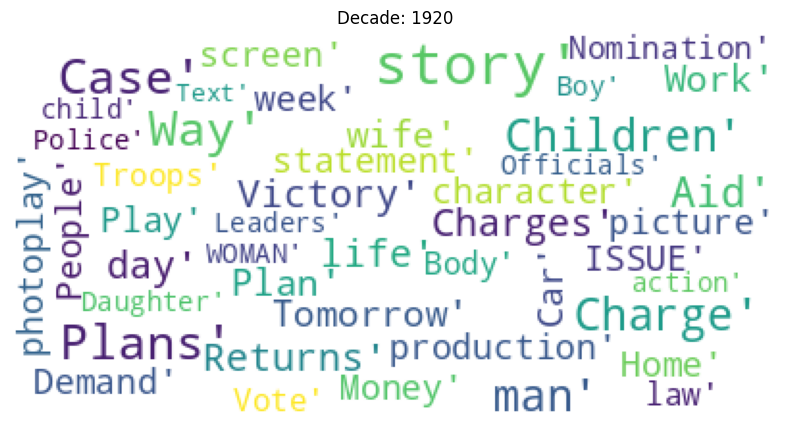

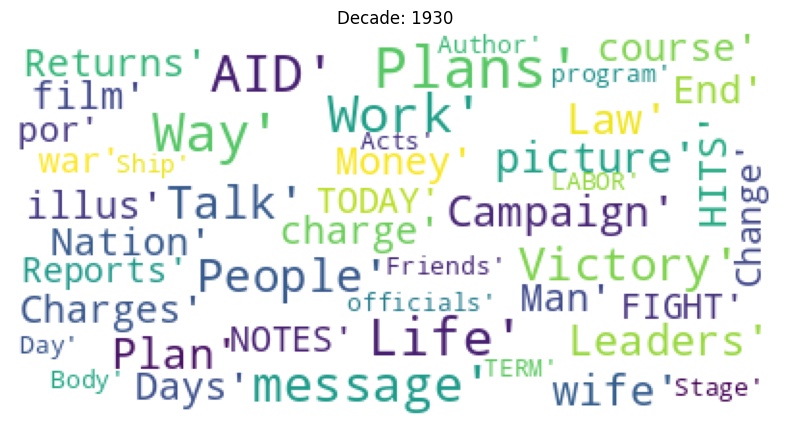

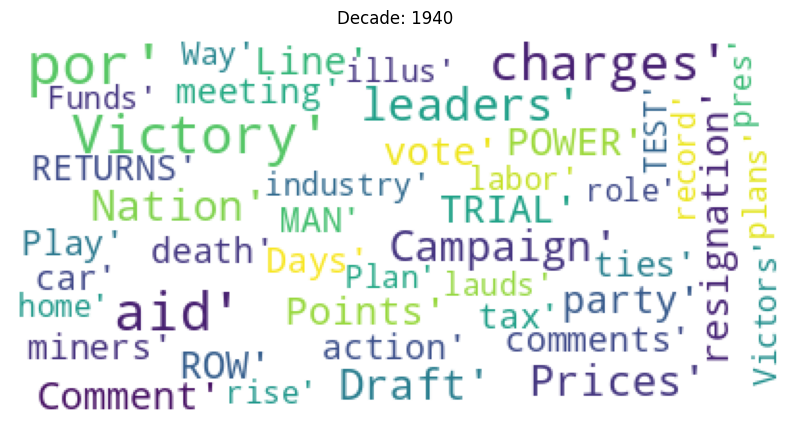

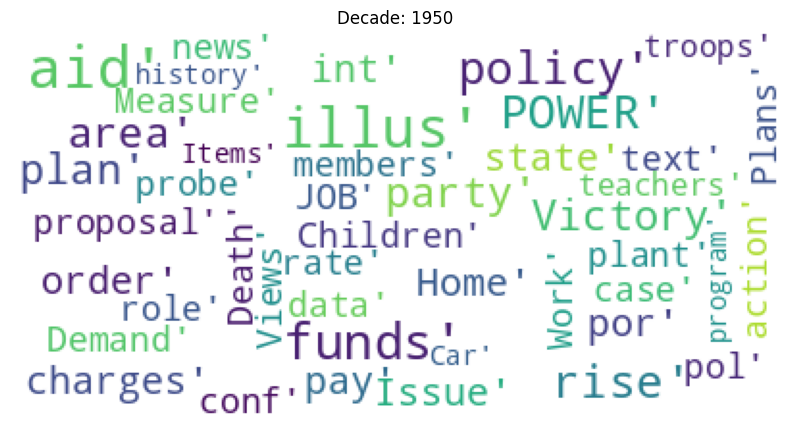

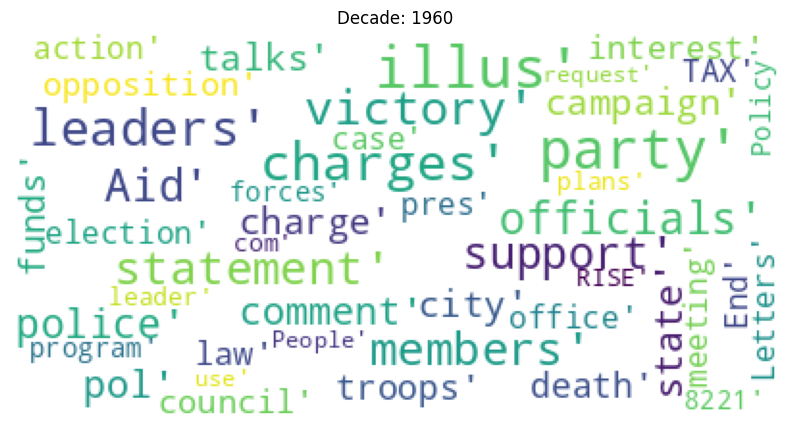

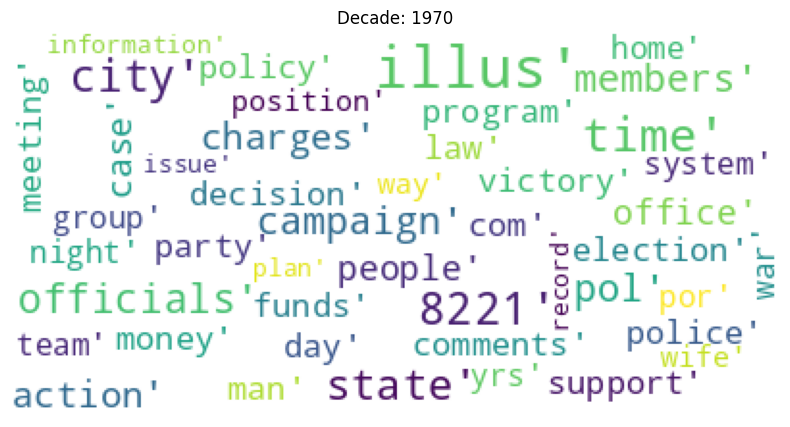

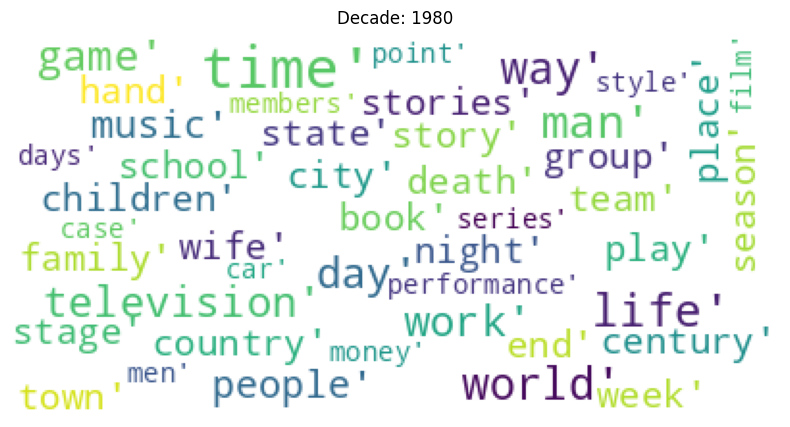

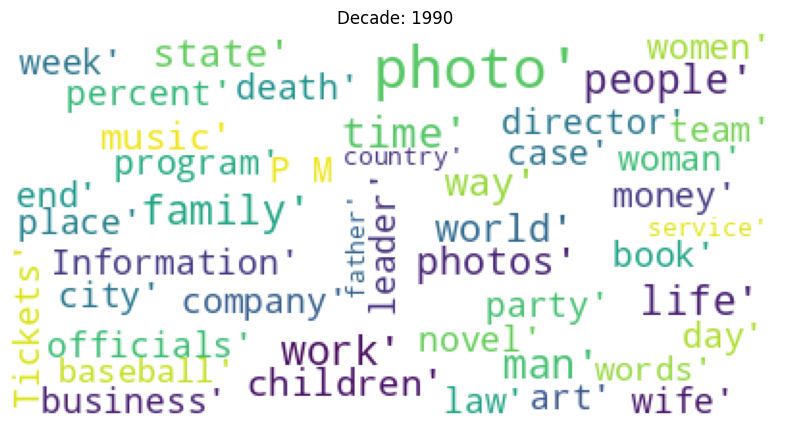

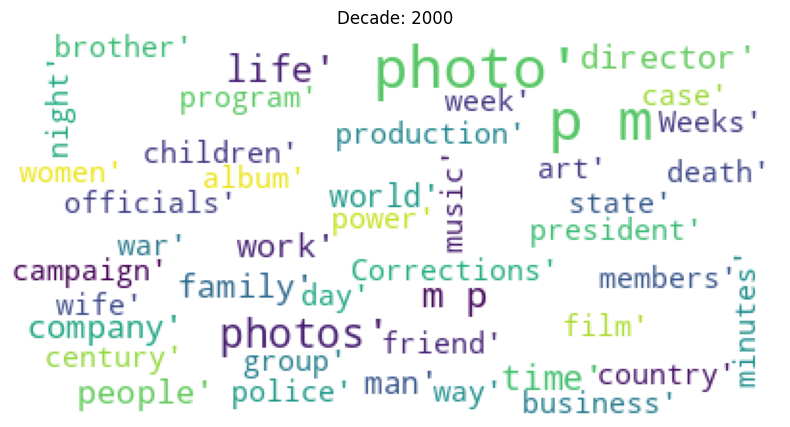

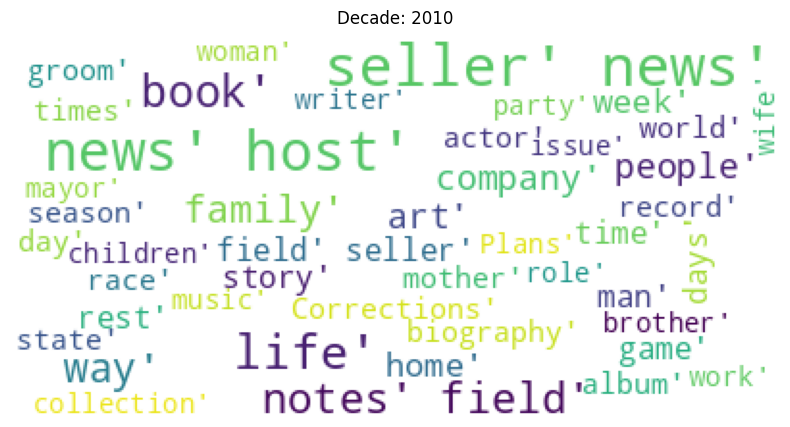

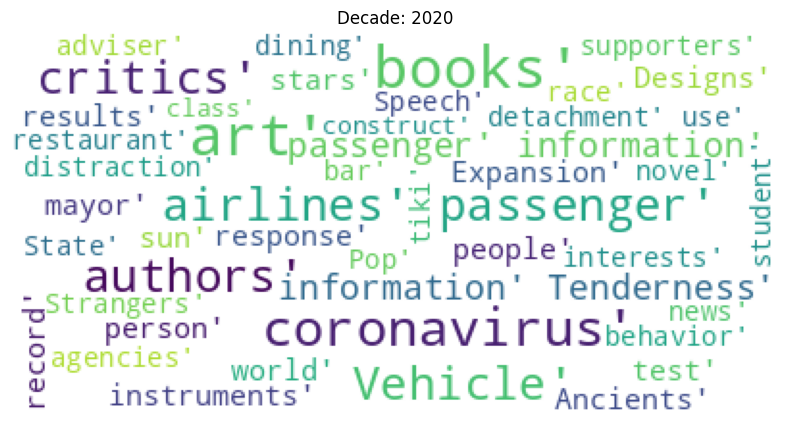

In [ ]:
decade = 1920
while decade < 2021:
    get_word_cloud_men(df_men, decade)
    decade += 10